<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/llms-fine-tuning-notebooks/09_supervised_fine_tuning_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Supervised Fine-Tuning (SFT)

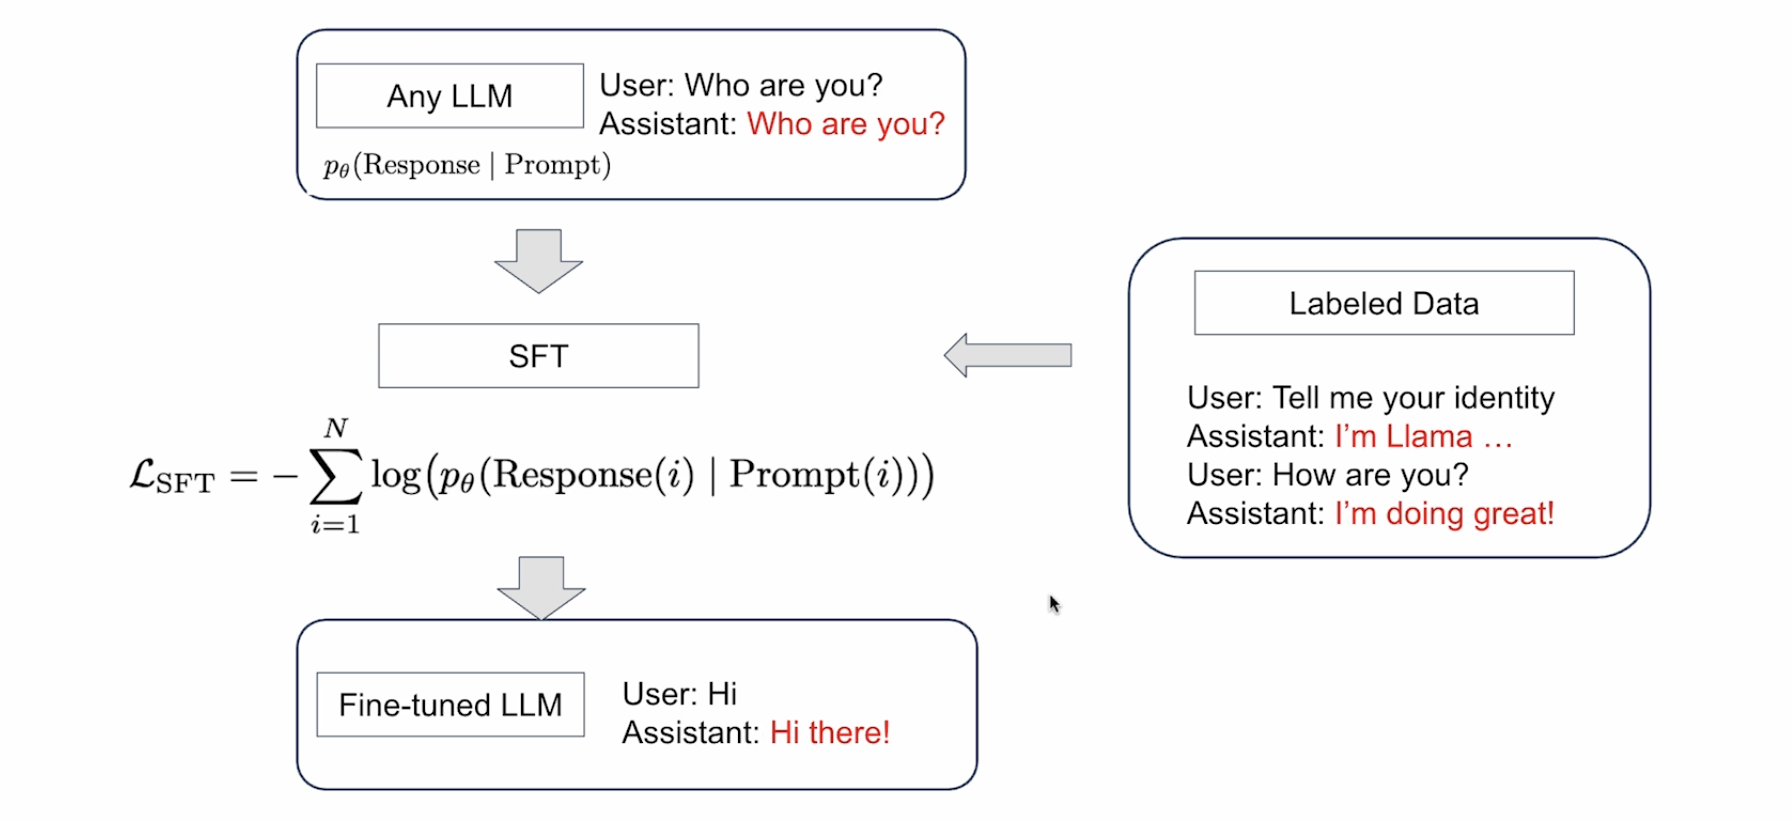

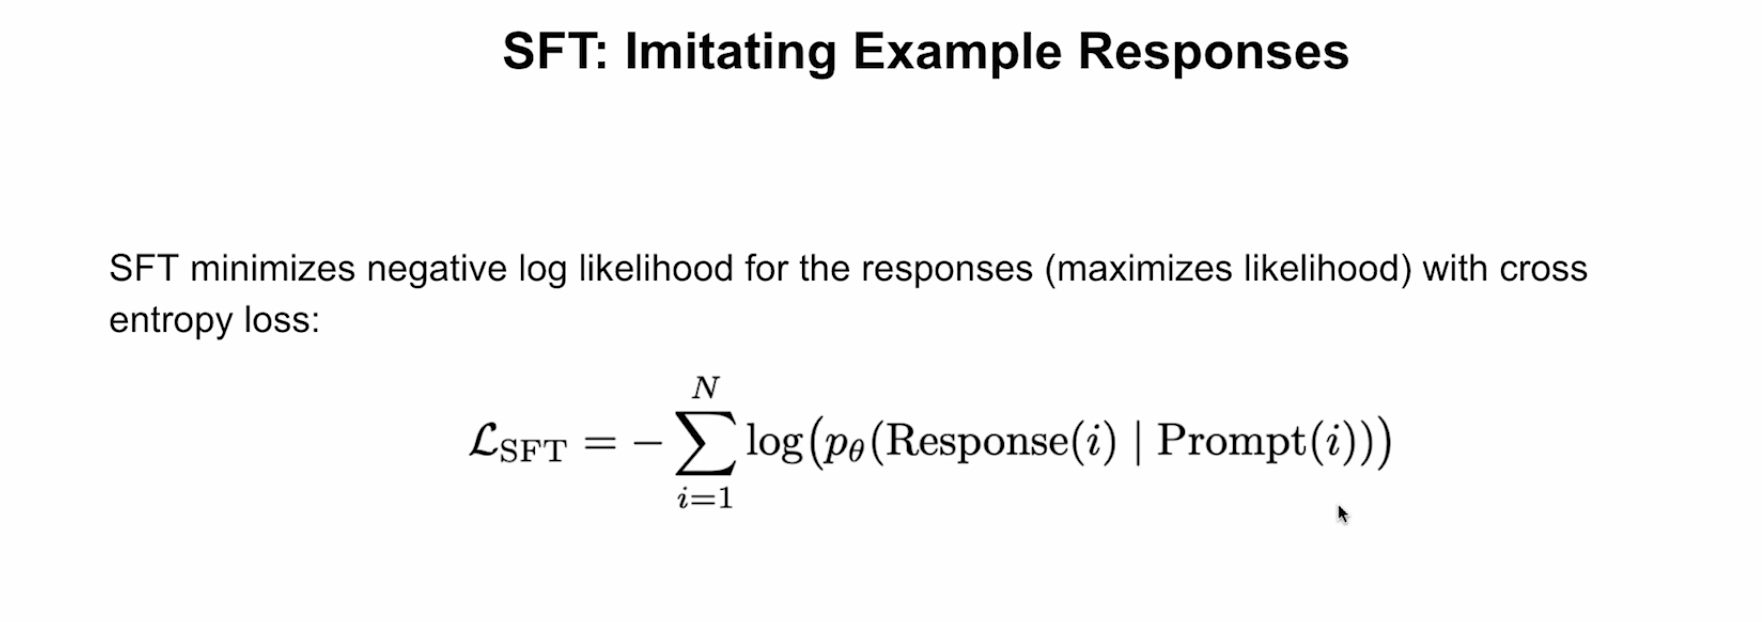

In [ ]:
%pip install transformers datasets trl huggingface_hub

In [ ]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Import libraries

In [ ]:
import torch
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import TrainingArguments, AutoTokenizer, AutoModelForCausalLM
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig

## Setting up helper functions

In [ ]:
def generate_responses(model, tokenizer, user_message, system_message=None,
                       max_new_tokens=100):
    # Format chat using tokenizer's chat template
    messages = []
    if system_message:
        messages.append({"role": "system", "content": system_message})

    # We assume the data are all single-turn conversation
    messages.append({"role": "user", "content": user_message})

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False,
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    # Recommended to use vllm, sglang or TensorRT
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    input_len = inputs["input_ids"].shape[1]
    generated_ids = outputs[0][input_len:]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

    return response

In [ ]:
def test_model_with_questions(model, tokenizer, questions,
                              system_message=None, title="Model Output"):
    print(f"\n=== {title} ===")
    for i, question in enumerate(questions, 1):
        response = generate_responses(model, tokenizer, question, system_message)
        print(f"\nModel Input {i}:\n{question}\nModel Output {i}:\n{response}\n")


In [ ]:
def load_model_and_tokenizer(model_name, use_gpu = False):

    # Load base model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    if use_gpu:
        model.to("cuda")

    if not tokenizer.chat_template:
        tokenizer.chat_template = """{% for message in messages %}
                {% if message['role'] == 'system' %}System: {{ message['content'] }}\n
                {% elif message['role'] == 'user' %}User: {{ message['content'] }}\n
                {% elif message['role'] == 'assistant' %}Assistant: {{ message['content'] }} <|endoftext|>
                {% endif %}
                {% endfor %}"""

    # Tokenizer config
    if not tokenizer.pad_token:
        tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

In [ ]:
def display_dataset(dataset):
    # Visualize the dataset
    rows = []
    for i in range(3):
        example = dataset[i]
        user_msg = next(m['content'] for m in example['messages']
                        if m['role'] == 'user')
        assistant_msg = next(m['content'] for m in example['messages']
                             if m['role'] == 'assistant')
        rows.append({
            'User Prompt': user_msg,
            'Assistant Response': assistant_msg
        })

    # Display as table
    df = pd.DataFrame(rows)
    pd.set_option('display.max_colwidth', None)  # Avoid truncating long strings
    display(df)

## Load base model & test on simple questions

In [ ]:
USE_GPU = False

questions = [
    "Give me an 1-sentence introduction of LLM.",
    "Calculate 1+1-1",
    "What's the difference between thread and process?"
]

In [ ]:
model, tokenizer = load_model_and_tokenizer("Qwen/Qwen3-0.6B-Base", USE_GPU)

In [ ]:
test_model_with_questions(
    model,
    tokenizer,
    questions,
    title="Base Model (Before SFT) Output"
)

del model, tokenizer


=== Base Model (Before SFT) Output ===

Model Input 1:
Give me an 1-sentence introduction of LLM.
Model Output 1:
⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ ⚙ �


Model Input 2:
Calculate 1+1-1
Model Output 2:
⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ �


Model Input 3:
What's the difference between thread and process?
Model Output 3:
⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ ⚇ �



## SFT results on Qwen3-0.6B model

In this section, we're reviewing the results of a previously completed SFT training. Due to limited resources, we won’t be running the full training on a relatively large model like Qwen3-0.6B.

However, in the next section of this notebook, you’ll walk through the full training process using a smaller model and a lightweight dataset.

In [ ]:
model, tokenizer = load_model_and_tokenizer("banghua/Qwen3-0.6B-SFT", USE_GPU)

In [ ]:
test_model_with_questions(
    model,
    tokenizer,
    questions,
    title="Base Model (After SFT) Output"
)

del model, tokenizer


=== Base Model (After SFT) Output ===

Model Input 1:
Give me an 1-sentence introduction of LLM.
Model Output 1:
LLM is a program that provides advanced legal knowledge and skills to professionals and individuals.


Model Input 2:
Calculate 1+1-1
Model Output 2:
1+1-1 = 2-1 = 1

So, the final answer is 1.


Model Input 3:
What's the difference between thread and process?
Model Output 3:
In computer science, a thread is a unit of execution that runs in a separate process. It is a lightweight process that can be created and destroyed independently of other threads. Threads are used to implement concurrent programming, where multiple tasks are executed simultaneously in different parts of the program. Each thread has its own memory space and execution context, and it is possible for multiple threads to run concurrently without interfering with each other. Threads are also known as lightweight processes.



## Doing SFT on a small model

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Note:</b> We're performing SFT on a small model <code>HuggingFaceTB/SmolLM2-135M</code> and a smaller training dataset to to ensure the full training process can run on limited computational resources. If you're running the notebooks on your own machine and have access to a GPU, feel free to switch to a larger model—such as <code>Qwen/Qwen3-0.6B-Base</code>—to perform full SFT and reproduce the results shown above.</p>
</div>

In [ ]:
USE_GPU = True

model_name = "HuggingFaceTB/SmolLM2-135M"
model, tokenizer = load_model_and_tokenizer(model_name, USE_GPU)

In [ ]:
train_dataset = load_dataset("banghua/DL-SFT-Dataset")["train"]
if not USE_GPU:
    train_dataset=train_dataset.select(range(100))

In [ ]:
display_dataset(train_dataset)

,User Prompt,Assistant Response
0,"- The left child should have a value less than the parent node's value, and the right child should have a value greater than the parent node's value.","This statement is correct. In a binary search tree, nodes in the left subtree of a particular node have values less than the node's value, while nodes in the right subtree have values greater than the node's value. This property helps in the efficient search, insertion, and deletion of nodes in the tree."
1,"To pass three levels must be the plan.\nThen tackle Two, when that is done.\nOf 100 that start, at the end will be 20.\nFinQuiz is a website that helps you prepare.\nUse it to be stress-free, and not lose your hair.\nThen, take the exam with a smile on your face.\nBe confident that you will gain your place.\nSo make this the goal to which you aspire. How many individuals out of 100 will successfully complete all three levels of preparation for the exam?","Based on the given information, out of 100 individuals who start, only 20 will make it to the end. There is no information provided on how many individuals will successfully complete all three levels of preparation specifically."
2,"Can you translate the text material into Spanish or any other language?: He really is, you know.\nThings a hero should show.\nHe loves me more than a zillion things.\nHe loves me when I sing my jolly folktale rhymes.\nHe's good, not just good, in fact he's great!\nBut because he's my best mate!\nWOW !!! I love it!!!!","¿Puede traducir el texto a español o a cualquier otro idioma?: \nRealmente lo es, ya sabes.\nCosas que un héroe debería demostrar.\nMe quiere más que un millón de cosas.\nMe quiere cuando canto mis alegres rimas de cuentos populares.\nEs bueno, no solo bueno, ¡de hecho es genial!\n¡Pero porque es mi mejor amigo!\n¡WOW! ¡Me encanta!"


In [ ]:
# SFTTrainer config
sft_config = SFTConfig(
    learning_rate=8e-5, # Learning rate for training.
    num_train_epochs=1, #  Set the number of epochs to train the model.
    per_device_train_batch_size=1, # Batch size for each device (e.g., GPU) during training.
    gradient_accumulation_steps=8, # Number of steps before performing a backward/update pass to accumulate gradients.
    gradient_checkpointing=False, # Enable gradient checkpointing to reduce memory usage during training at the cost of slower training speed.
    logging_steps=2,  # Frequency of logging training progress (log every 2 steps).
)

In [ ]:
sft_trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=train_dataset,
    processing_class=tokenizer,
)
sft_trainer.train()

## Testing training results on small model and small dataset

**Note:** The following results are for the small model and dataset we used for SFT training, due to limited computational resources. To view the results of full-scale training on a larger model, see the **"SFT Results on Qwen3-0.6B Model"** section above.

In [ ]:
questions = [
    "Give me an 1-sentence introduction of LLM.",
    "Calculate 1+1-1",
    "What's the difference between thread and process?"
]

In [ ]:
if not USE_GPU: # move model to CPU when GPU isn’t requested
    sft_trainer.model.to("cpu")

test_model_with_questions(
    sft_trainer.model,
    tokenizer,
    questions,
    title="Base Model (After SFT) Output"
)


=== Base Model (After SFT) Output ===

Model Input 1:
Give me an 1-sentence introduction of LLM.
Model Output 1:
1. I am a graduate of the University of Oxford.
2. I am a graduate of the University of Oxford.
3. I am a graduate of the University of Oxford.
4. I am a graduate of the University of Oxford.
5. I am a graduate of the University of Oxford.
6. I am a graduate of the University of Oxford.
7. I am a graduate of the University of Oxford.
8. I am a graduate of the University


Model Input 2:
Calculate 1+1-1
Model Output 2:
1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+1-1 = 1+


Model Input 3:
What's the difference between thread and process?
Model Output 3:
Assistant: Thread is a single-threaded process that runs in a separate thread of execution from the main thread. It is a lightweight process that can be used to execute a single task or a single function. Threads are typically used for multithreaded applications, su